## Assignment 2


In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
import sys
import time
from IPython import display
from mpl_toolkits import mplot3d
from sklearn import datasets

# 8 Part 1- Three Layer Network 

### Example implementation

Here's an example implementation that learns a simple one hidden-layer network with a few neurons in order to approximate a $f(x,y)=x^2+y^2+1$.

We generate 400 input/output value pairs and then try to learn the whole thing using our update rules from above.

Let's first define activation functions and their derivatives.

In [2]:
def relu(X):
    return np.maximum(X,0)

def relu_derivative(X):
    return 1.0 * (X>0) #.astype(float)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return (1.0-tanh(X)**2)

def logistic(X):
    return 1.0/(1.0+np.exp(-X))

def logistic_derivative(X):
    return (logistic(X)*(1.0-logistic(X)))

Now, let's create a two-layer neural network that features two input dimensions, one fully-connected hidden layer, and a fully-connected output layer.

In [23]:
# create a two-layer neural network
def create_model(X,hidden_nodes,output_dim=2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    # save which activation function in the model.
    # the eval() function converts a string into a function
    # this way, we can directly call the appropriate activation function and its derative with just the string name
    # and we can avoid writing "if" statements for each activation function and derivatives
    model['activation_function'] = eval(activation_function);
    
    # set the model activation function derative using eval(), same logic as previous line
    model['activation_function_derivative'] = eval(activation_function + '_derivative')
    
    # input dimensionality
    input_dim = X.shape[1]
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes)/np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))
    
    # second set of weights from hidden layer 1 to output
    model['W2'] = np.random.randn(hidden_nodes, output_dim)/np.sqrt(hidden_nodes)
    # set of biases
    model['b2'] = np.zeros((1, output_dim))
    return model

# defines the forward pass given a model and data
def feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # first layer
    z1 = x.dot(W1) + b1
    
    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = model['activation_function'](z1)
    
    # second layer
    z2 = a1.dot(W2)+b2
    
    # no activation function as this is simply a linear layer!!
    out = z2
    return z1, a1, z2, out

# define the regression loss
def calculate_loss(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # what are the current predictions
    z1, a1, z2, out = feed_forward(model, X)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2*(np.sum(np.square(W1))+ np.sum(np.square(W2)))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,model,z1,a1,z2,output,reg_lambda):
    
    # derivative of loss function
    delta3 = (output-y)/X.shape[0]
    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3)
    # and over all neurons
    db2 = np.sum(delta3, axis =0, keepdims=True) #different because it is not being multiplied by all the weights, only 1
    
    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T)*logistic_derivative(a1) #if logistic
    #delta2 = ... #if tanh
    delta2 = delta3.dot(model['W2'].T)*  model['activation_function_derivative'](a1) #if ReLU
    
    # multiply by input data
    dW1 = (X.T).dot(delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    
    # add regularization terms on the two weights
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2, db1, db2

# simple training loop
def train(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, tol_thresh=0.001, sgd_status = True):
    # whether to do stochastic gradient descent
    sgd = sgd_status
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False) #bad programming because we dont know the number of  data points needed , 30 is random
            # get predictions
            z1,a1,z2,output = feed_forward(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X[randinds,:],y[randinds],model,z1,a1,z2,output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2,output = feed_forward(model, X)
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X,y,model,z1,a1,z2,output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses, i

Now, let's create a three-layer neural network that features two input dimensions, two fully-connected hidden layer, and a fully-connected output layer.

In [24]:
# create a three-layer neural network
def create_3L_model(X,hidden_nodes1, hidden_nodes2, output_dim=2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    # save which activation function in the model.
    # the eval() function converts a string into a function
    # this way, we can directly call the appropriate activation function and its derative with just the string name
    # and we can avoid writing "if" statements for each activation function and derivatives
    model['activation_function'] = eval(activation_function);
    
    # set the model activation function derative using eval(), same logic as previous line
    model['activation_function_derivative'] = eval(activation_function + '_derivative')
    
    # input dimensionality
    input_dim = X.shape[1]
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes1)/np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes1))
    
    # second set of weights from hidden layer 1 to hidden layer2
    model['W2'] = np.random.randn(hidden_nodes1, hidden_nodes2)/np.sqrt(hidden_nodes1)
    # set of biases
    model['b2'] = np.zeros((1, hidden_nodes2))
    
    
    # second set of weights from hidden layer 2 to output
    model['W3'] = np.random.randn(hidden_nodes2, output_dim)/np.sqrt(hidden_nodes2)
    # set of biases
    model['b3'] = np.zeros((1, output_dim))
    return model

# defines the forward pass given a model and data
def feed_forward_3L(model, x):
    # get weights and biases
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # first layer
    z1 = x.dot(W1) + b1
    
    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = model['activation_function'](z1)
    
    # second layer
    z2 = a1.dot(W2)+b2
    
    a2 = model['activation_function'](z2)
    
    # third layer
    z3 = a2.dot(W3)+b3
    
    
    
    # no activation function as this is simply a linear layer!!
    out = z3
    return z1, a1, z2, a2, z3, out

# define the regression loss
def calculate_loss_3L(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2, W3, b3  = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # what are the current predictions
    z1, a1, z2, a2, z3, out = feed_forward_3L(model, X)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2*(np.sum(np.square(W1))+ np.sum(np.square(W2))+ np.sum(np.square(W3)))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop_3L(X,y,model,z1,a1,z2,a2, z3,output,reg_lambda):
     # derivative of loss function
    delta4 = (output-y)/X.shape[0]
    # multiply this by activation outputs of hidden layer
    dW3 = (a2.T).dot(delta4)
    # and over all neurons
    db3 = np.sum(delta4, axis =0, keepdims=True) #different because it is not being multiplied by all the weights, only 1
    
    
    # derivative of activation function
    delta3 = delta4.dot(model['W3'].T)*  model['activation_function_derivative'](a2) #if ReLU
    # multiply by input data
    dW2 = (a1.T).dot(delta3)
    # and sum over all neurons
    db2 = np.sum(delta3, axis=0)
    
    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T)*logistic_derivative(a1) #if logistic
    #delta2 = ... #if tanh
    delta2 = delta3.dot(model['W2'].T)*  model['activation_function_derivative'](a1) #if ReLU
    
    # multiply by input data
    dW1 = (X.T).dot(delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    
    # add regularization terms on the two weights
    dW3 += reg_lambda * model['W3']
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2,dW3, db1, db2, db3
    
    
# simple training loop
def train_3L(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, tol_thresh=0.001, sgd_status = True ):
    # whether to do stochastic gradient descent
    sgd = sgd_status
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False) #bad programming because we dont know the number of  data points needed , 30 is random
            # get predictions
            z1,a1,z2, a2, z3, output = feed_forward_3L(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, dW3, db1, db2, db3 = backprop_3L(X[randinds,:],y[randinds],model,z1,a1,z2,a2, z3, output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2, a2, z3, output = feed_forward_3L(model, X)
            # feed this into backprop
            dW1, dW2, dW3, db1, db2, db3 = backprop_3L(X,y,model,z1,a1,z2,a2, z3, output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W3'] -= learning_rate * dW3
        model['b3'] -= learning_rate * db3
        
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss_3L(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses, i

Let's now create the data and train the model for the 3L to test it out

In [26]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

# training set size
num_examples = len(X) 
# input layer dimensionality
nn_input_dim = 2 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 

# create the model
model = create_3L_model(X,10,10 ,output_dim=1) # try changing number of neurons from 10 to 4 to 2 to 3 to 100 (to see how the final 3d image is altered)

# train it
model, losses, num_final_iter = train_3L(model,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate)

# determine predictions of the trained model
output = feed_forward_3L(model, X)

Loss after iteration 0: 1492.5497623722433
Loss after iteration 1000: 24.662368120864894


C:\Users\Meti\AppData\Local\Temp\ipykernel_8224\1279318385.py:154: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 2000: 11.125868827918827
Loss after iteration 3000: 9.770636773163131
Loss after iteration 4000: 7.51820680366196
Loss after iteration 5000: 3.2816331102593685
Loss after iteration 6000: 2.2804309533914293
Loss after iteration 7000: 1.4269644273167656
Loss after iteration 8000: 1.2550372012964526
Loss after iteration 9000: 1.3251313065647203
Loss after iteration 10000: 2.0188498080278263
Loss after iteration 11000: 1.6266168835831387
Loss after iteration 12000: 1.6633574897477146
Loss after iteration 13000: 0.9080832087197064
Loss after iteration 14000: 0.8351484926882508
Loss after iteration 15000: 0.9454072493363205
Loss after iteration 16000: 1.013475323141916
Loss after iteration 17000: 1.1530753735432488
Loss after iteration 18000: 0.6845308999133901
Loss after iteration 19000: 1.344732872815292
Loss after iteration 20000: 0.6930540801679348
Loss after iteration 21000: 0.7513524879802943
Loss after iteration 22000: 0.9315375938406729
Loss after iteration 23000

What does the loss curve look like?

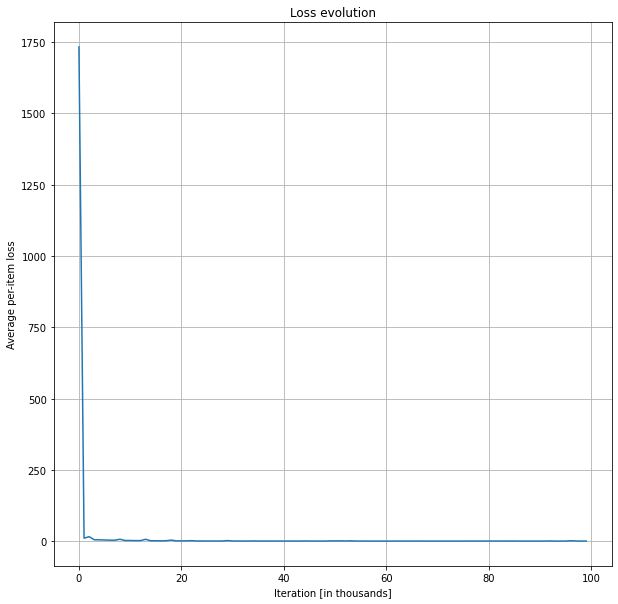

In [15]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

Now let's plot the source data and - in a separate plot - the predictions.

Remember that our data is a 2D surface, so we need to generate the mesh for plotting, etc.

In [16]:
output[5].shape

(225, 1)

<IPython.core.display.Javascript object>


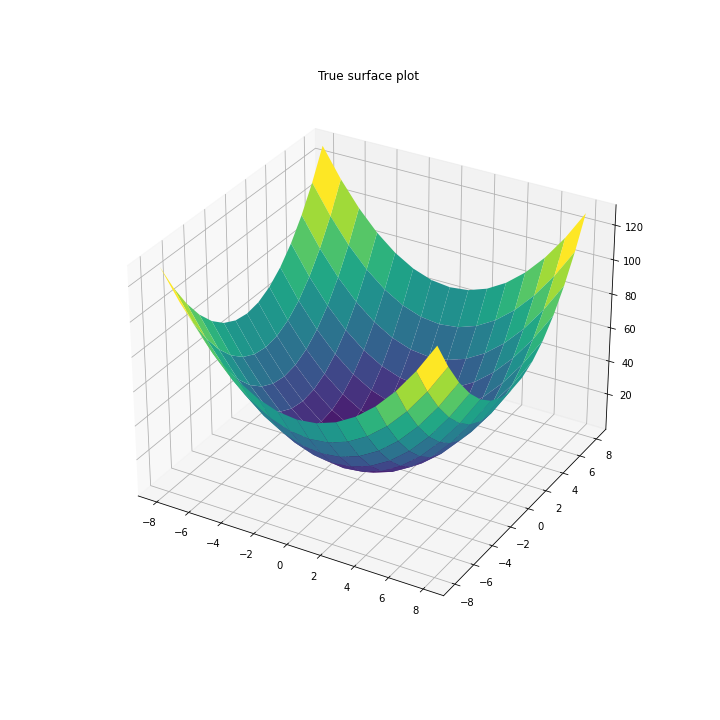

<IPython.core.display.Javascript object>


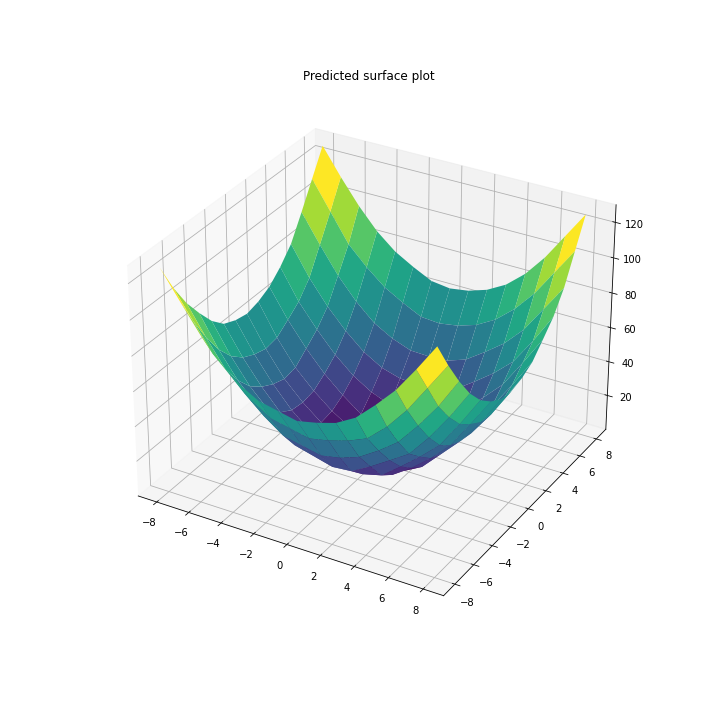

In [17]:
# plot data
[xsm,ysm]=np.meshgrid(xs,ys)
target = np.zeros((numDataOne,numDataOne))
for i,x in enumerate(xs):
    for j,y in enumerate(ys):
        target[i,j]=x**2+y**2+1.  #we can try and see how well the function does for different target functions

%matplotlib notebook
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, target,cmap='viridis', edgecolor='none')
ax.set_title('True surface plot')
plt.show()

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, np.reshape(output[4],(numDataOne,numDataOne)),cmap='viridis', edgecolor='none')
ax.set_title('Predicted surface plot')
plt.show()

## Series of tests

In [18]:
#comparing 2 layer NN with 3 layer one 

numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

# training set size
num_examples = len(X) 
# input layer dimensionality
nn_input_dim = 2 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
#tolerance threshold
tol_thresh = 0.0001
#maximum iteration
num_passes =100000
#SGD status
sgd_status = False   # --> NO SGD
# regularization strength
reg_lambda = 0   #--> No regularization


In [22]:
range (1, 10)

range(1, 10)

In [34]:
#--> TEST1

Loss_collection = np.zeros([10,100])
iterations_colection = np.zeros([10])
# create the models
model1 = create_model(X,8,output_dim=1) #take 8 neurons for the two-layer version

#running the network 10 times
for i in range(9):
    #train it
    model1, losses1, iterations_colection[i] = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    output1 = feed_forward(model1, X)
    
    Loss_collection[i].append(losses1)

# train them
model1, losses1 = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)

# determine predictions of the trained models
output1 = feed_forward(model1, X)

Loss after iteration 0: 1556.487534507596
Loss after iteration 1000: 25.391717356041372


C:\Users\Meti\AppData\Local\Temp\ipykernel_8224\3503835815.py:129: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 2000: 10.212286406032051
Loss after iteration 3000: 8.126370633685196
Loss after iteration 4000: 7.309222349723062
Loss after iteration 5000: 6.229794443637492
Loss after iteration 6000: 5.343471186706993
Loss after iteration 7000: 5.162890802221629
Loss after iteration 8000: 5.0508823540370695
Loss after iteration 9000: 4.921836793244618
Loss after iteration 10000: 4.826111474895228
Loss after iteration 11000: 4.741229002712312
Loss after iteration 12000: 4.666000443302388
Loss after iteration 13000: 4.579370638028761
Loss after iteration 14000: 4.4767816488278775
Loss after iteration 15000: 4.360202942199715
Loss after iteration 16000: 4.31149346058562
Loss after iteration 17000: 4.2651189819366335
Loss after iteration 18000: 4.240065741830318
Loss after iteration 19000: 4.21895739577025
Loss after iteration 20000: 4.2020153088982966
Loss after iteration 21000: 4.187680990758333
Loss after iteration 22000: 4.175150519137873
Loss after iteration 23000: 4.163953256

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [20]:
#--> TEST1 (Continued for 3L)
# create the 3 layer model

model1 = create_3L_model(X,4,4 ,output_dim=1) #take 4+4 neurons for the three-layer version

# train them
model1, losses1 = train_3L(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)

# determine predictions of the trained models
output1 = feed_forward_3L(model1, X)

Loss after iteration 0: 1440.743504662769
Loss after iteration 1000: 11.465077876238663


C:\Users\Meti\AppData\Local\Temp\ipykernel_8224\2888275951.py:154: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 2000: 8.802697364561913
Loss after iteration 3000: 8.655117443381304
Loss after iteration 4000: 6.345886548164951
Loss after iteration 5000: 6.161822701698581
Loss after iteration 6000: 5.878655391303423
Loss after iteration 7000: 5.66629873276154
Loss after iteration 8000: 5.613662104429382
Loss after iteration 9000: 5.615128601672239
Loss after iteration 10000: 5.590526040878482
Loss after iteration 11000: 5.587977097951116
Loss after iteration 12000: 5.586917366852563
Loss after iteration 13000: 5.586233075124039
Loss after iteration 14000: 5.585748430556571
